### Sample Jupyter Notebook for testing/translating Script

In [44]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Connect to MetaTrader 5 terminal

In [45]:
# Initialize connection to MT5
if not mt5.initialize():
    print("initialize() failed, error code =", mt5.last_error())
    quit()

# User Configuration Settings


In [46]:
ApplyRsifilter = False  # True to apply RSI filter, False to not apply
ApplyAtrfilter = False  # True to apply ATR filter, False to not apply
ApplyThreshold = True  # True to apply threshold
Threshold = 100  # Threshold in ticks

# Define thresholds for different currencies


In [47]:
thresholds = {
    "USD": 2,
    "EUR": 2,
    "JPY": 300,
    "GBP": 6,
    "CHF": 2,
    "AUD": 2
}

# Liquidity level thresholds in percentage


In [48]:
min_auto_tp_thresholds = {
    "default": 100,
    "USD": 5,
    "EUR": 10,
    "JPY": 100,
    "GBP": 50,
    "CHF": 5,
    "AUD": 5
}

# Other User Input

In [50]:
last_tp_limits = {
    "default": 250,
    "USD": 15,
    "EUR": 10,
    "JPY": 800,
    "GBP": 60,
    "CHF": 15,
    "AUD": 15
}
peak_type = 21
enable_second_strategy = True
min_gap_seconds = {
    "default": 650,
    "USD": 15,
    "EUR": 15,
    "JPY": 650,
    "GBP": 50,
    "CHF": 15,
    "AUD": 15
}
max_allow_into_zone = 0.25

# Define symbol, time frame and paramaters

In [51]:
symbol = "EURUSD"
timeframe = mt5.TIMEFRAME_H3  # 3-hour data

# Define the updated period
is_range = False
from_date = pd.to_datetime("2024-02-01")
to_date = pd.to_datetime("2024-03-16")

# Support and resistance proximity settings


In [52]:
is_proximity = True
support_resistance_proximity = 0.01

# Request historical data

In [53]:
if is_range:
    rates = mt5.copy_rates_range(symbol, timeframe, from_date, to_date)
else:
    rates = mt5.copy_rates_range(symbol, timeframe, pd.to_datetime('2023-12-01'), pd.to_datetime('2024-04-15'))

# Convert data to DataFrame

In [54]:
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# Calculate EMAs manually

In [55]:
df['wavy_h'] = df['high'].ewm(span=34, adjust=False).mean()
df['wavy_c'] = df['close'].ewm(span=34, adjust=False).mean()
df['wavy_l'] = df['low'].ewm(span=34, adjust=False).mean()
df['ema_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['tunnel1'] = df['close'].ewm(span=144, adjust=False).mean()
df['tunnel2'] = df['close'].ewm(span=169, adjust=False).mean()

# Display EMAs to verify
print(df[['time', 'wavy_h', 'wavy_c', 'wavy_l', 'ema_12', 'tunnel1', 'tunnel2']].head())



                 time    wavy_h    wavy_c    wavy_l    ema_12   tunnel1  \
0 2023-12-01 00:00:00  1.090290  1.090190  1.087640  1.090190  1.090190   
1 2023-12-01 03:00:00  1.090347  1.090183  1.087773  1.090170  1.090188   
2 2023-12-01 06:00:00  1.090396  1.090222  1.087890  1.090278  1.090198   
3 2023-12-01 09:00:00  1.090443  1.090197  1.087931  1.090203  1.090192   
4 2023-12-01 12:00:00  1.090439  1.090053  1.087910  1.089813  1.090157   

    tunnel2  
0  1.090190  
1  1.090188  
2  1.090196  
3  1.090192  
4  1.090162  


# Plot EMAs

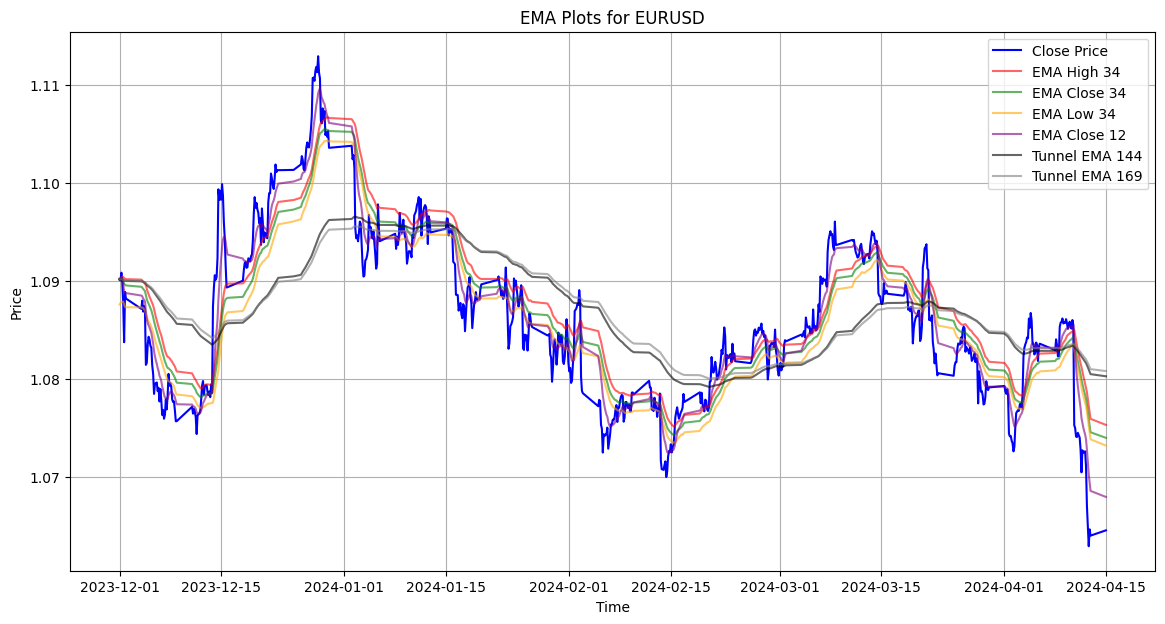

In [56]:
plt.figure(figsize=(14, 7))
plt.plot(df['time'], df['close'], label='Close Price', color='blue')
plt.plot(df['time'], df['wavy_h'], label='EMA High 34', color='red', alpha=0.6)
plt.plot(df['time'], df['wavy_c'], label='EMA Close 34', color='green', alpha=0.6)
plt.plot(df['time'], df['wavy_l'], label='EMA Low 34', color='orange', alpha=0.6)
plt.plot(df['time'], df['ema_12'], label='EMA Close 12', color='purple', alpha=0.6)
plt.plot(df['time'], df['tunnel1'], label='Tunnel EMA 144', color='black', alpha=0.6)
plt.plot(df['time'], df['tunnel2'], label='Tunnel EMA 169', color='gray', alpha=0.6)
plt.title(f'EMA Plots for {symbol}')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# RSI Calculation


In [60]:
# Define the period for RSI calculation
period = 14

# Calculate price changes
delta = df['close'].diff()

# Separate gains and losses
gain = (delta.where(delta > 0, 0))
loss = (-delta.where(delta < 0, 0))

# Calculate the average gain and loss
avg_gain = gain.rolling(window=period, min_periods=1).mean()
avg_loss = loss.rolling(window=period, min_periods=1).mean()

# Avoid division by zero and calculate RS
rs = avg_gain / avg_loss.replace(to_replace=0, method='ffill')

# Calculate RSI
df['rsi'] = 100 - (100 / (1 + rs))

# Optional: Adjust the first 14 periods of RSI as they might be inaccurate
df['rsi'][:period] = np.nan


C:\Users\Owner\AppData\Local\Temp\ipykernel_10256\3462826129.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi'][:period] = np.nan


# Peak and Dip Detection


In [62]:
def find_peaks_dips(series, frame_size):
    mid = frame_size // 2
    peaks = np.full(len(series), np.nan)
    dips = np.full(len(series), np.nan)
    for i in range(mid, len(series) - mid):
        window = series[i-mid:i+mid+1]
        if series[i] == max(window):
            peaks[i] = series[i]
        if series[i] == min(window):
            dips[i] = series[i]
    return peaks, dips

df['peak'], df['dip'] = find_peaks_dips(df['close'], peak_type)

# First Strategy Conditions


In [63]:
df['long_condition'] = (df['open'] > np.maximum(df['wavy_c'], df['wavy_h'], df['wavy_l'])) & \
                       (np.minimum(df['wavy_c'], df['wavy_h'], df['wavy_l']) > np.maximum(df['tunnel1'], df['tunnel2'])) & \
                       (df['rsi'] < 70)
df['short_condition'] = (df['open'] < np.minimum(df['wavy_c'], df['wavy_h'], df['wavy_l'])) & \
                        (np.maximum(df['wavy_c'], df['wavy_h'], df['wavy_l']) < np.minimum(df['tunnel1'], df['tunnel2'])) & \
                        (df['rsi'] > 30)

C:\Users\Owner\AppData\Local\Temp\ipykernel_10256\4149929852.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['long_condition'] = (df['open'] > np.maximum(df['wavy_c'], df['wavy_h'], df['wavy_l'])) & \
C:\Users\Owner\AppData\Local\Temp\ipykernel_10256\4149929852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  (np.minimum(df['wavy_c'], df['wavy_h'], df['wavy_l']) > np.maximum(df['tunnel1'], df['tunnel2'])) & \
C:\Users\Owner\AppData\Local\Temp\ipykernel_10256\4149929852.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

# Second Strategy Conditions


In [64]:
df['second_long_condition'] = (df['close'].shift(1) < df[['wavy_c', 'wavy_h', 'wavy_l']].max(axis=1).shift(1)) & \
                              (df['close'] > df[['wavy_c', 'wavy_h', 'wavy_l']].max(axis=1)) & \
                              (df['close'] < df[['tunnel1', 'tunnel2']].min(axis=1))
df['second_short_condition'] = (df['close'].shift(1) > df[['wavy_c', 'wavy_h', 'wavy_l']].min(axis=1).shift(1)) & \
                               (df['close'] < df[['wavy_c', 'wavy_h', 'wavy_l']].min(axis=1)) & \
                               (df['close'] > df[['tunnel1', 'tunnel2']].max(axis=1))


# Visualize

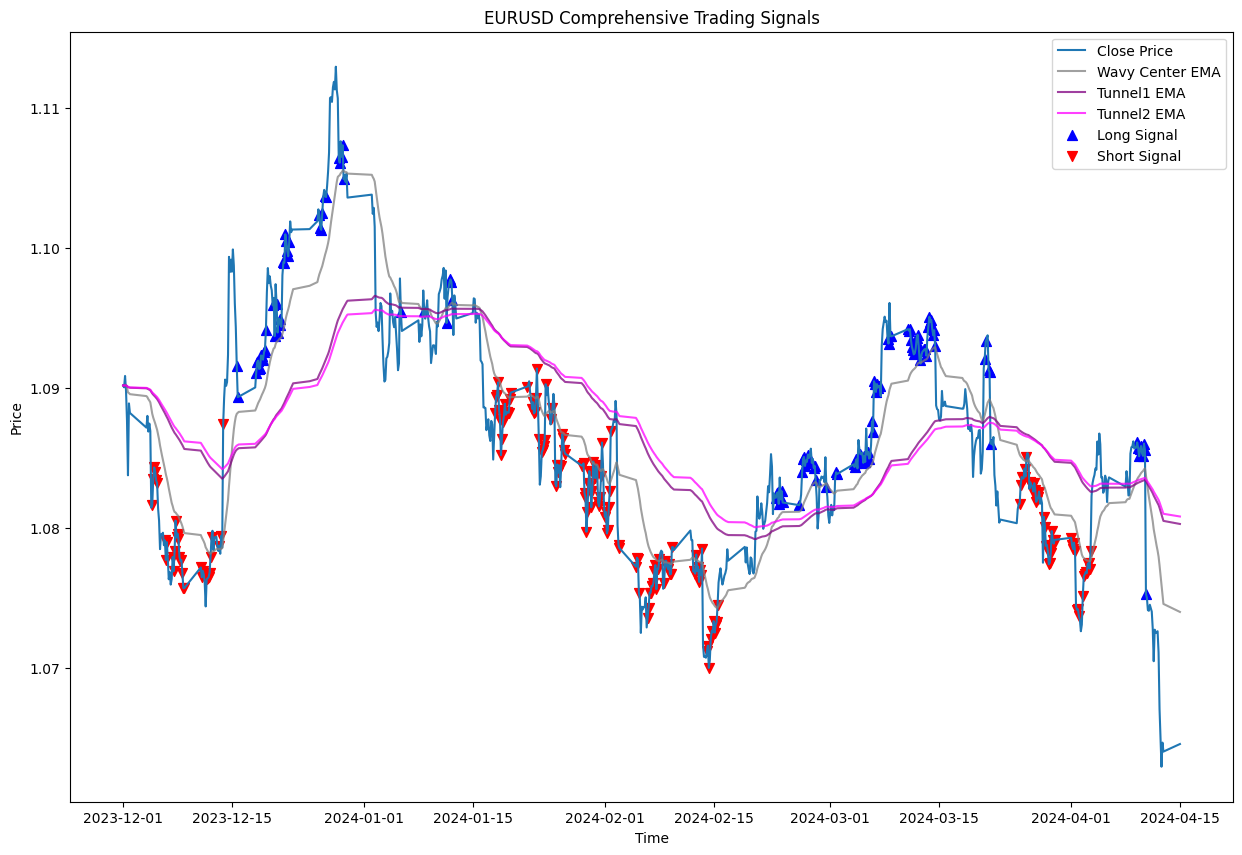

True

In [65]:
plt.figure(figsize=(15, 10))
plt.plot(df['time'], df['close'], label='Close Price')
plt.plot(df['time'], df['wavy_c'], label='Wavy Center EMA', color='gray', alpha=0.75)
plt.plot(df['time'], df['tunnel1'], label='Tunnel1 EMA', color='purple', alpha=0.75)
plt.plot(df['time'], df['tunnel2'], label='Tunnel2 EMA', color='magenta', alpha=0.75)
plt.scatter(df[df['long_condition']]['time'], df[df['long_condition']]['close'], color='blue', label='Long Signal', s=50, marker='^')
plt.scatter(df[df['short_condition']]['time'], df[df['short_condition']]['close'], color='red', label='Short Signal', s=50, marker='v')
plt.title(f'{symbol} Comprehensive Trading Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Disconnect from MT5
mt5.shutdown()


# Disconnect from MetaTrader 5 terminal

In [10]:
mt5.shutdown()

True